# RNN for japanese character classification - Test Notebook

In [1]:
from google.colab import drive, files
import os
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/
if not os.path.exists('japanese-character-classification'):
    !git clone https://github.com/erikhelmut/japanese-character-classification.git
    %cd japanese-character-classification/notebooks/
else:
    %cd japanese-character-classification/notebooks/
    !git pull
#%pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks
Already up to date.


In [4]:
import time
import math
import random

import sys
import inspect
import os
import glob
import csv

import numpy as np

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

#currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#parentdir = os.path.dirname(currentdir)
#sys.path.insert(0,parentdir)

sys.path.append("..")

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Define network structure

In [5]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, n_characters):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
       
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.rnn(x, h0)
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

## Define helper functions for neural network's training

In [7]:
def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

In [8]:
def determine_accuracy():
    # locations of datasets
    paths = ["../data/test", "../data/train"]
    
    for p in paths:
    
        character_files, all_characters = load_data(path=p)

        with torch.no_grad():
            n_correct = 0
            n_samples = 0

            for character in all_characters:
                # all files from one character
                for file in character_files[character]:
                    file_tensor = file_to_tensor(file).to(device)
                    # get output
                    output = model(file_tensor).to(device)
                    # get character from output
                    guess = character_from_output(output)
                    n_samples += 1
                    if guess == character:
                        n_correct += 1
        
        # calculate accuracy
        if p == "../data/test":
            acc_test = 100.0 * n_correct / n_samples
        elif p == "../data/train":
            acc_train = 100.0 * n_correct / n_samples

    return acc_test, acc_train

## Defining hyperparameters of neural network's training

In [9]:
# load train dataset
character_files, all_characters = load_data(path="../data/train/")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 2

learning_rate = 0.005

## Start training loop

In [10]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

all_acc_test = []
all_acc_train = []
all_acc_time = []

print_every = 5000
plot_every = 1000
acc_every = 500
n_iters = 50000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # determine accuracy with timestamp
    if i % acc_every == 0:
        acc_test, acc_train = determine_accuracy()
        all_acc_test.append(acc_test)
        all_acc_train.append(acc_train)
        all_acc_time.append(time.time() - start)

5000 10% (2m 1s) 1.6359 ../data/train/e__46600.csv / o ✗ (e)
10000 20% (3m 32s) 1.2144 ../data/train/i__03501.csv / a ✗ (i)
15000 30% (5m 5s) 1.2387 ../data/train/u__96553.csv / i ✗ (u)
20000 40% (6m 36s) 0.8132 ../data/train/o__03230.csv / o ✓
25000 50% (8m 7s) 0.0443 ../data/train/u__89555.csv / u ✓
30000 60% (9m 36s) 0.0022 ../data/train/e__17381.csv / e ✓
35000 70% (11m 7s) 3.0357 ../data/train/a__44364.csv / o ✗ (a)
40000 80% (12m 39s) 0.0225 ../data/train/o__31750.csv / o ✓
45000 90% (14m 10s) 0.0045 ../data/train/e__30746.csv / e ✓
50000 100% (15m 42s) 0.0014 ../data/train/e__26726.csv / e ✓


In [11]:
np.savetxt("../evaluation/RNN_1x128_acc_test.csv", all_acc_test, delimiter =",")
np.savetxt("../evaluation/RNN_1x128_acc_train.csv", all_acc_train, delimiter =",")
np.savetxt("../evaluation/RNN_1x128_acc_time.csv", all_acc_time, delimiter =",")
np.savetxt("../evaluation/RNN_1x128_loss.csv", all_losses, delimiter =",")

## Plot LOSS-function

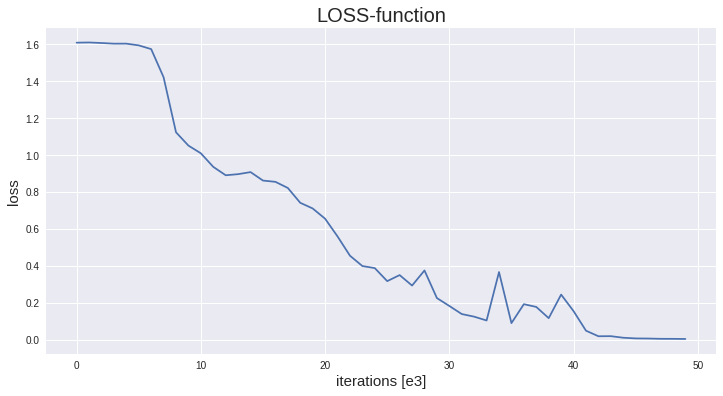

In [12]:
# create figure
mpl.style.use("seaborn")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations [e3]", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [13]:
%cd ../models/
FILE = "2.0.1-lstm-network-model-test-128x1.pth"
torch.save(model.state_dict(), FILE)
%cd ../notebooks/

/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/models
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


## Load model

In [14]:
%cd ../models/
FILE = "2.0.1-lstm-network-model-test-128x1.pth"
loaded_model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()
%cd ../notebooks/

/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/models
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
../data/test/a__88470.csv / a ✓
../data/test/a__94789.csv / a ✓
../data/test/a__96486.csv / a ✓
../data/test/a__97545.csv / a ✓
../data/test/a__98539.csv / a ✓
../data/test/e__70433.csv / e ✓
../data/test/e__76682.csv / e ✓
../data/test/e__82254.csv / e ✓
../data/test/e__83191.csv / e ✓
../data/test/e__84585.csv / e ✓
../data/test/i__75461.csv / i ✓
../data/test/i__81833.csv / i ✓
../data/test/i__88644.csv / i ✓
../data/test/i__89095.csv / i ✓
../data/test/i__91889.csv / i ✓
../data/test/o__54903.csv / o ✓
../data/test/o__63253.csv / o ✓
../data/test/o__67824.csv / a ✗ (o)
../data/test/o__72419.csv / o ✓
../data/test/o__76748.csv / o ✓
../data/test/u__81848.csv / u ✓
../data/test/u__82120.csv / u ✓
../data/test/u__83897.csv / u ✓
../data/test/u__85976.csv / u ✓
../data/test/u__88458.csv / u ✓
../data/test/u__93521.csv / u ✓

accuracy = 96.15 %



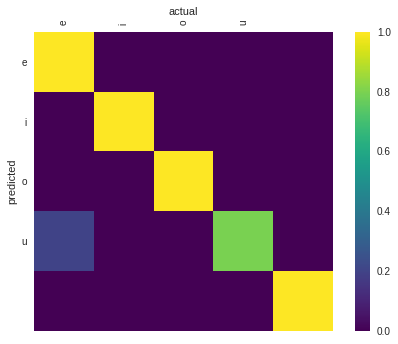

In [17]:
# load test dataset
character_files, all_characters = load_data(path="../data/test/")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            # get output
            output = loaded_model(file_tensor).to(device)
            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, "/", guess, correct)

# normalize by dividing every row by its sum
for i in range(n_characters):
    confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)
cax = ax.matshow(confusion.numpy(), cmap="viridis")
fig.colorbar(cax)

# set up axes
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(all_characters, rotation=90)
ax.set_yticklabels(all_characters)
ax.set_xlabel("actual")
ax.xaxis.set_label_position("top") 
ax.set_ylabel("predicted")

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()